In [1]:
import xarray as xr
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
import matplotlib.pyplot as plt

In [3]:
path = 'C:/Users/ABHISHEK/OneDrive/Documents/SSH Data/ostst-single-layer-fd-lat-40-urms-5-kf-13-kr-4-beta.nc'

ds = xr.open_dataset(path)

In [5]:
ds

<xarray.Dataset>
Dimensions:          (j: 1, kl: 11439, x: 256, y: 256, z: 1, t: 1826)
Coordinates:
  * j                (j) float64 1.0
  * kl               (kl) float64 0.0 1.0 2.0 ... 1.144e+04 1.144e+04 1.144e+04
  * x                (x) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * y                (y) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * z                (z) float64 0.0
  * t                (t) datetime64[ns] 1970-01-01 1970-01-02 ... 1974-12-31
Data variables: (12/19)
    Lx               float64 ...
    Ly               float64 ...
    Lz               float64 ...
    h                (j) float64 ...
    k                (kl) float64 ...
    l                (kl) float64 ...
    ...               ...
    A0bar_realp      (kl, j) float64 ...
    A0bar_imagp      (kl, j) float64 ...
    tau0             float64 ...
    ssh              (t, y, x) float64 ...
    A0_realp         (t, kl, j) float64 ...
    A0_imagp         (t, kl, j) float64 ...
Attributes:
    source:                    Created with the WaveVortexModel version 3
    model_version:             3.0
    date_created:              28-Feb-2025 16:35:34
    history:                   28-Feb-2025 16:35:34: file created.~          ...
    references:                Early, J., Lelong, M., & Sundermeyer, M. (2021...
    WVTransform:               WVTransformSingleMode
    WVNonlinearFluxOperation:  WVNonlinearFluxQGForced
    beta:                      1.7535936850315176e-11
    r:                         1.4137166941154068e-08
    alpha:                     7.068583470577034e-10
    nu_xy:                     59.6006962601987
    shouldUseLinearDynamics:   0

In [7]:
ssh_series = ds.ssh.isel(y=0, x=0).load().values

In [11]:
ssh_series.shape

(1826,)

In [13]:
nt = ssh_series.shape[0]
t = np.arange(nt)[:, None]                    
pred_steps = 10                               
t_future = np.arange(nt, nt + pred_steps)[:, None]

In [15]:
kernel = ConstantKernel(1.0) * RBF(length_scale=10.0) + WhiteKernel(noise_level=0.1)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=2)

In [17]:
mask = ~np.isnan(ssh_series)
gp.fit(t[mask], ssh_series[mask])

C:\Users\ABHISHEK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=2, normalize_y=True)

In [19]:
ssh_pred, ssh_std = gp.predict(t_future, return_std=True)

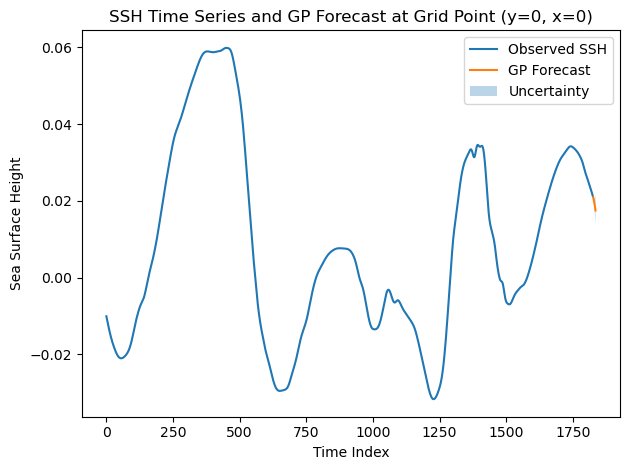

In [23]:
plt.figure()
plt.plot(t.ravel(), ssh_series, label="Observed SSH")
plt.plot(t_future.ravel(), ssh_pred, label="GP Forecast")
plt.fill_between(
    t_future.ravel(),
    ssh_pred - 2 * ssh_std,
    ssh_pred + 2 * ssh_std,
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("Time Index")
plt.ylabel("Sea Surface Height")
plt.title("SSH Time Series and GP Forecast at Grid Point (y=0, x=0)")
plt.legend()
plt.tight_layout()
plt.show()